# Seminární práce I z předmětu Počítačové zpracování signálu (KI/PZS)

**Autor**: Martin Žoha

**Datum**: 21. 6. 2025

## Úvod

Seminární práce se zabývá zpracováním EKG signálů. Zdrojem signálů jsou databáze
 [Physionet Brno University of Technology ECG Quality Database (BUT QDB)](https://physionet.org/content/butqdb/1.0.0/) a 
 [MIT-BIH Normal Sinus Rhythm Database (NSRDB)](https://physionet.org/content/nsrdb/1.0.0/). Samotné zpracování je rozděleno do dvou hlavních částí. Předmětem první části je načtení dat do prostředí Python a výpočet tepové frekvence z načtených dat. Druhá část práce je zaměřena na detekci anomálií v signálech. Kód k jednotlivým částem je rozdělen do logických celků a připraven i k použití bez doprovodného komentáře. Všechny funkce a třídy jsou opatřeny extenzivní dokumentací ve stylu Google. Vybrané části jsou doplněny komentáři. Celý notebook je připraven k jednorázovému spuštění, ale případné úpravy jsou možné.

## Výpočet tepové frekvence z EKG signálu

### Zadání první části

Ve zdrojové databázi najdete celkem 18 měření EKG signálu pro různé věkové skupiny. Signál
obsahuje různé anomálie a nemusí být vždy centralizován podle vodorovné osy. EKG signál
obsahuje dominantní peaky, které se nazývají R vrcholy. Vzdálenost těchto vrcholů určuje dobu
mezi jednotlivými tepy. Počet tepů za minutu je tedy počet R vrcholů v signálu o délce jedné
minuty. Navrhněte algoritmus, který bude automaticky detekovat počet R vrcholů v EKG
signálech a prezentujte tepovou frekvenci při jednotlivých jízdách/měřeních. Vás algoritmus
následně otestujte na databázi MIT-BIH https://physionet.org/content/nsrdb/1.0.0/ a
prezentujte jeho úspěšnost vzhledem k anotovaným datům z databáze.

### Obecný postup zpracování první části

Data jsou načtena pomocí knihovny [Waveform Database Software Package (WFDB) for Python](https://physionet.org/content/wfdb-python/4.1.0/) a předzpracována pro následné použití. V signálu jsou detekovány pozice R vrcholů. Ze zjištěných pozic je určen rozestup R vrcholů a vypočtena tepová frekvence v tepech za minutu. Přesnost výsledků je ověřena na anotovaných datech MIT-BIH.

In [22]:
# ECG Analysis Pipeline: R-peak Detection and Anomaly Detection
# =============================================================================

from dataclasses import dataclass
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.ndimage import uniform_filter1d
from scipy.signal import butter, find_peaks, sosfiltfilt
from typing import Dict, List, Tuple
import wfdb


# Download datasets
# wfdb.dl_database("butqdb", "source1", keep_subdirs=False)
# wfdb.dl_database("nsrdb", "source2", keep_subdirs=False)


### 1. Předzpracování signálu

V této fázi jsou připraveny funkce k předzpracování signálu. Funkce `filter_ecg` slouží k vyčištění EKG signálu od rušení a šumu, které ztěžují jeho správnou analýzu. Používá k tomu Butterworthův filtr, což je druh filtru, který propustí jen určité frekvence tím, že zeslabí nebo úplně potlačí složky signálu, které leží mimo zadané frekvenční pásmo. V tomto případě je zvoleno frekvenční pásmo mezi 0.5 a 40 Hz. Řád filtru určuje, jak ostrý je přechod mezi povolenými a filtrovanými frekvencemi. Čím vyšší řád je, tím ostřejší přechod. Zvolený řád je kompromisem mezi čitelností signálu a jeho poškozením. Tyto hodnoty jsou zvoleny iterativně. Postupně byly zkoušeny hodnoty, aby v následném hodnocení detekce R vrcholů vycházely co nejlepší výsledky.

Tento filtr má hladký průběh a nezpůsobuje ostré změny ve tvaru signálu. Filtr je vytvořen ve stabilní podobě, aby dobře fungoval i pro delší nebo složitější signály. Aby se nezměnil tvar EKG vln (například QRS komplex), používá se funkce `sosfiltfilt`, která filtr aplikuje dvakrát – nejdřív dopředu a pak zpátky. Díky tomu nedochází k posunu ve tvaru vln. Výsledkem je EKG signál, který je zbavený pomalých výkyvů (například způsobených pohybem nebo dýcháním) i vysokofrekvenčního šumu (např. elektrické rušení), a je tak připravený pro další analýzu.

Funkce `normalize_signal` přijme filtrovaný signál a zarovná ho tak, aby měl průměrnou hodnotu nula a standardní odchylku jedna. Dělá to tak, že od každé hodnoty v signálu odečte celkový průměr a pak výsledek vydělí směrodatnou odchylkou - tento postup se nazývá z-score normalizace. Hlavní důvod, proč se to dělá, je odstranění rozdílů v amplitudě mezi různými záznamy, zatímco křivka srdečního rytmu zůstane stejná, což je klíčové pro správnou analýzu.

V těchto funkcích jsou využity předpřipravené funkce `butter` a `sosfiltfilt` z knihovny scipy. Tato implementace je zvolena kvůli čitelnosti kódu, rychlosti zpracování a přesnosti výsledků.

Výsledkem výše uvedeného procesu je vertikálně zarovnaný a normalizovaný signál zbavený šumu, což je žádoucí pro detekci R vrcholů. Toto komplexní předzpracování naopak negativně ovlivňuje detekci anomálií v druhé části práce.

In [23]:
# =============================================================================
#  1. SIGNAL PREPROCESSING
# =============================================================================
def filter_ecg(signal: np.ndarray, fs: int, low: float = 0.5,
               high: float = 40.0) -> np.ndarray:
    """Apply bandpass filter to ECG signal to remove noise and artifacts.

    Applies a 4th-order Butterworth bandpass filter to remove baseline drift
    (low-frequency noise) and high-frequency noise from ECG signals. The
    default frequency range (0.5-40 Hz) captures the diagnostically relevant
    components of ECG signals while filtering out motion artifacts and
    power line interference.

    Args:
        signal (np.ndarray): Input ECG signal as 1D numpy array.
        fs (int): Sampling frequency of the signal in Hz.
        low (float, optional): Low cutoff frequency in Hz. Defaults to 0.5.
            Removes baseline drift and respiratory artifacts.
        high (float, optional): High cutoff frequency in Hz. Defaults to 40.0.
            Removes high-frequency noise while preserving QRS morphology.

    Returns:
        np.ndarray: Filtered ECG signal with same shape as input.

    Raises:
        ValueError: If low >= high or if frequencies are outside valid range.
        TypeError: If signal is not a numpy array or fs is not numeric.

    Example:
        >>> ecg_data = np.random.randn(1000)  # Sample ECG signal
        >>> filtered_ecg = filter_ecg(ecg_data, fs=250)
        >>> print(f"Original shape: {ecg_data.shape}")
        >>> print(f"Filtered shape: {filtered_ecg.shape}")

    Note:
        Uses zero-phase filtering (sosfiltfilt) to avoid phase distortion,
        which is critical for maintaining ECG morphology and timing.
    """
    nyquist = 0.5 * fs
    sos = butter(4, [low/nyquist, high/nyquist], btype="band", output="sos")
    return sosfiltfilt(sos, signal)

def normalize_signal(signal: np.ndarray) -> np.ndarray:
    """Normalize signal to zero mean and unit variance (z-score normalization).

    Standardizes the signal by subtracting the mean and dividing by the
    standard deviation. This normalization is essential for ECG analysis
    as it removes amplitude variations between different leads or recordings
    while preserving the relative morphology of cardiac events.

    Args:
        signal (np.ndarray): Input signal as 1D numpy array to be normalized.

    Returns:
        np.ndarray: Normalized signal with mean ≈ 0 and std ≈ 1, same shape
            as input.

    Raises:
        ValueError: If signal has zero variance (all values identical).
        TypeError: If signal is not a numpy array.

    Example:
        >>> raw_signal = np.array([1, 2, 3, 4, 5])
        >>> normalized = normalize_signal(raw_signal)
        >>> print(f"Original mean: {np.mean(raw_signal):.2f}")
        >>> print(f"Normalized mean: {np.mean(normalized):.2f}")
        >>> print(f"Normalized std: {np.std(normalized):.2f}")

    Note:
        This implementation assumes the signal is stationary. For long
        recordings, consider segmented normalization to handle non-stationarity.
    """
    return (signal - np.mean(signal)) / np.std(signal)

def preprocess_ecg(signal: np.ndarray, fs: int) -> np.ndarray:
    """Complete ECG preprocessing pipeline: filtering and normalization.

    Performs comprehensive preprocessing of ECG signals by applying bandpass
    filtering followed by z-score normalization. This two-step process
    removes noise artifacts and standardizes signal amplitude, preparing
    the data for downstream analysis such as R-peak detection, arrhythmia
    classification, or morphology analysis.

    Args:
        signal (np.ndarray): Raw ECG signal as 1D numpy array.
        fs (int): Sampling frequency of the signal in Hz. Common values
            are 250, 360, or 500 Hz for clinical ECG recordings.

    Returns:
        np.ndarray: Preprocessed ECG signal (filtered and normalized) with
            same shape as input. Signal will have zero mean, unit variance,
            and frequency content limited to 0.5-40 Hz.

    Raises:
        ValueError: If sampling frequency is non-positive or if signal
            processing parameters are invalid.
        TypeError: If inputs are not of expected types.

    Example:
        >>> # Simulate noisy ECG signal
        >>> t = np.linspace(0, 10, 2500)  # 10 seconds at 250 Hz
        >>> ecg_raw = np.sin(2*np.pi*1.2*t) + 0.1*np.random.randn(len(t))
        >>> ecg_clean = preprocess_ecg(ecg_raw, fs=250)
        >>> print(f"Raw signal range: [{ecg_raw.min():.2f}, "
        ...       f"{ecg_raw.max():.2f}]")
        >>> print(f"Processed signal stats: mean={np.mean(ecg_clean):.3f}, "
        ...       f"std={np.std(ecg_clean):.3f}")

    Note:
        Uses default filter parameters (0.5-40 Hz) optimized for clinical
        ECG analysis. For specific applications, consider using filter_ecg()
        and normalize_signal() separately with custom parameters.
    """
    filtered = filter_ecg(signal, fs)
    return normalize_signal(filtered)


### 2. Detekce R vrcholů a výpočet tepové frekvence

Funkce `detect_r_peaks` funguje jako digitální detektor srdečního rytmu, který dokáže v EKG záznamu najít přesně vrcholy R vln, které odpovídají hlavní kontrakci srdečních komor. Celý proces probíhá ve čtyřech krocích. Nejprve funkce vypočítá, jak rychle se signál mění z vzorku na vzorek (derivace) a tyto změny umocní na druhou, čímž zvýrazní prudké skoky typické pro QRS komplexy, pak tento "zostřený" signál vyhladí pomocí klouzavého průměru přes 80 milisekund, což je [typická doba trvání QRS komplexu](https://www.healio.com/cardiology/learn-the-heart/ecg-review/ecg-interpretation-tutorial/qrs-complex), následně najde všechny vrcholy, které překračují adaptivní práh nastavený na 90. percentil. Tento práh byl opět stanoven iterativně. Začátek byl 98 a postupně snižován, dokud se zlepšovala přesnost detekce. Vrcholy musí být od sebe vzdálené alespoň 300 milisekund, aby se zabránilo falešným detekcím při rychlém srdečním rytmu. Autor uvažuje maximální tepovou frekvenci 200 tepů za minutu, což může být nedostatečné v případě závažných srdečních onemocnění nebo extrémních sportovních výkonů. Pokud se nejedná o žádnou z výše uvedených, jedná se o anomálii. Pro potřeby práce s databázemi BUTQDB a NSRDB je ovšem postačující. Stejně tak by měla být postačující pro práci s dlouhodobými měřeními typu Holter a podobným post hoc zpracováním. Detekce se nakonec vrátí k původnímu signálu a kolem každého detekovaného místa v okně 50 milisekund najde skutečný nejvyšší bod, který představuje přesnou polohu R vrcholu. Celý tento postup je inspirovaný slavným Pan-Tompkinsovým algoritmem a je navržen tak, aby spolehlivě rozpoznal srdeční rytmus i v zašuměných záznamech, přičemž dokáže pracovat s různými tvary EKG signálů a frekvencemi vzorkování.

Funkce `calculate_bpm` sleduje, jak se tepová frekvence mění v průběhu času během celého EKG záznamu. Celý záznam je rozdělen na stejně dlouhé časové úseky (obvykle po 60 sekundách) a v každém z těchto úseků je vypočteno, kolik srdečních úderů se odehrálo. Funkce postupně prochází každé časové okno, najde všechny R vrcholy (které jsou detekované v předešlém kroku) spadající do daného intervalu, spočítá je a přepočítá na standardní jednotku tepů za minutu pomocí jednoduchého vzorce: počet úderů krát 60 děleno délkou okna v sekundách. Výsledkem je pak časová řada hodnot tepové frekvence, kde každá hodnota odpovídá začátku příslušného časového okna, což umožňuje sledovat, jak se srdeční rytmus vyvíjel během celého vyšetření. Tento přístup je užitečný pro analýzu variability srdeční frekvence a pro detekci abnormalit, které se mohou projevit postupně v čase, nikoli jen v jednotlivých srdečních cyklech. V této práci je funkce použita pouze k výpočtu průměrné tepové frekvence v průběhu celého měření. To může být dále využito k monitorování fyzické zdatnosti, hladiny stresu a dalších.

In [24]:
# =============================================================================
#  2. R-PEAKS DETECTION AND BPM COMPUTATION
# =============================================================================
def detect_r_peaks(signal: np.ndarray, fs: int) -> np.ndarray:
    """Detect R-peaks using Pan-Tompkins inspired algorithm.

    Implements a modified Pan-Tompkins algorithm for QRS complex detection
    in ECG signals. The algorithm uses differentiation, squaring, and moving
    average integration to enhance QRS complexes, followed by adaptive
    thresholding and peak refinement to accurately locate R-peaks.

    The algorithm consists of four main steps:
    1. Differentiation and squaring to emphasize slope changes
    2. Moving average integration to smooth the signal
    3. Adaptive thresholding with minimum distance constraints
    4. Peak refinement in the original signal domain

    Args:
        signal (np.ndarray): Preprocessed ECG signal as 1D numpy array.
            Should be filtered and normalized for optimal performance.
        fs (int): Sampling frequency in Hz. Common values are 250, 360,
            or 500 Hz for clinical ECG recordings.

    Returns:
        np.ndarray: Array of R-peak indices (sample positions) in the
            original signal. Returns empty array if no peaks detected.

    Raises:
        ValueError: If sampling frequency is non-positive or signal is empty.
        TypeError: If inputs are not of expected types.

    Example:
        >>> # Detect R-peaks in a 10-second ECG recording
        >>> ecg_signal = preprocess_ecg(raw_ecg, fs=250)
        >>> r_peaks = detect_r_peaks(ecg_signal, fs=250)
        >>> print(f"Detected {len(r_peaks)} R-peaks")
        >>> # Convert to time domain
        >>> peak_times = r_peaks / 250.0  # seconds
        >>> print(f"First peak at {peak_times[0]:.2f} seconds")

    Note:
        - Uses 80ms integration window (typical QRS duration: 60-120ms)
        - Minimum peak distance of 300ms prevents double detection
        - Peak refinement searches ±50ms around detected locations
        - Threshold set at 90th percentile for adaptive performance
        - Algorithm assumes heart rate between 20-200 BPM
    """
    # Differentiate and square to emphasize QRS slope changes
    diff = np.diff(signal, append=signal[-1])
    squared = np.square(diff)

    # Moving average integration to smooth and enhance QRS complexes
    window_size = int(0.08 * fs)  # 80ms window for QRS enhancement
    kernel = np.ones(window_size, dtype=np.float32) / window_size
    integrated = np.convolve(squared, kernel, mode="same")

    # Find peaks with adaptive threshold and minimum distance constraint
    threshold = np.percentile(integrated, 90)  # Adaptive threshold
    min_distance = int(0.3 * fs)  # 300ms minimum (prevents >200 BPM)

    peaks, _ = find_peaks(integrated, height=threshold,
                          distance=min_distance)

    # Refine peak locations in original signal for accurate R-peak timing
    search_window = int(0.05 * fs)  # 50ms search window around detection

    r_peaks = np.array([peak + np.argmax(
        np.abs(signal[
            max(0, peak - search_window): min(len(signal), peak + search_window)]
            ))
            - search_window for peak in peaks if peak - search_window >= 0
            and peak + search_window < len(signal)])

    return np.array(r_peaks)

def calculate_bpm(r_peaks: np.ndarray, fs: int, duration_sec: float,
                  window_sec: int = 60) -> Tuple[np.ndarray, np.ndarray]:
    """Calculate heart rate (BPM) in sliding time windows.

    Computes instantaneous heart rate by counting R-peaks within sliding
    time windows. This approach provides time-resolved heart rate analysis
    suitable for detecting heart rate variability and trends over time.

    Args:
        r_peaks (np.ndarray): Array of R-peak indices from detect_r_peaks().
        fs (int): Sampling frequency in Hz used for time conversion.
        duration_sec (float): Total duration of the ECG recording in seconds.
        window_sec (int, optional): Window size for BPM calculation in
            seconds. Defaults to 60. Smaller windows provide higher
            temporal resolution but may be less stable.

    Returns:
        Tuple[np.ndarray, np.ndarray]: A tuple containing:
            - bpm_values: Array of heart rate values in beats per minute
            - time_minutes: Array of time points in minutes corresponding
              to each BPM value (window centers)

    Raises:
        ValueError: If duration_sec is negative or window_sec is non-positive.
        TypeError: If inputs are not of expected types.

    Example:
        >>> # Calculate BPM for 5-minute ECG recording
        >>> r_peaks = detect_r_peaks(ecg_signal, fs=250)
        >>> bpm, time_points = calculate_bpm(r_peaks, fs=250,
        ...                                  duration_sec=300, window_sec=60)
        >>> print(f"Average heart rate: {np.mean(bpm):.1f} BPM")
        >>> print(f"Heart rate range: {np.min(bpm):.1f}-{np.max(bpm):.1f}")
        >>>
        >>> # Plot heart rate over time
        >>> import matplotlib.pyplot as plt
        >>> plt.plot(time_points, bpm)
        >>> plt.xlabel("Time (minutes)")
        >>> plt.ylabel("Heart Rate (BPM)")

    Note:
        - Returns empty arrays if no R-peaks provided
        - BPM calculated as: (peaks_in_window * 60) / window_duration
        - Windows that extend beyond recording duration are truncated
        - For recordings shorter than window_sec, consider using smaller
          window sizes or instantaneous heart rate calculations
        - Time points represent the start of each window
    """
    if len(r_peaks) == 0:
        return np.array([]), np.array([])

    # Calculate number of complete windows that fit in the duration
    n_windows = int(duration_sec // window_sec)
    if n_windows == 0:
        # Handle case where duration is shorter than window size
        return np.array([]), np.array([])

    window_samples = int(window_sec * fs)
    bpm_values = np.zeros(n_windows, dtype=np.float32)
    time_minutes = np.arange(n_windows, dtype=np.float32) * (window_sec / 60)

    bin_edges = np.arange(0, (n_windows + 1) * window_samples, window_samples)
    counts, _ = np.histogram(r_peaks, bins=bin_edges)
    bpm_values[:] = counts * 60 / window_sec

    return bpm_values, time_minutes

### 3. Zpracování jednotlivých souborů

Tento kód představuje kompletní systém pro automatickou analýzu EKG záznamů schopný zpracovat celé soubory s EKG daty a vyhodnotit srdeční aktivitu. Celý proces začíná načtením EKG souboru ve standardním WFDB formátu. Systém nejprve přečte hlavičku souboru, aby zjistil základní parametry jako vzorkovací frekvenci, a pak načte samotný signál, přičemž automaticky vybere standardní Lead II (druhý svod), který je preferovaný kvůli tomu, že signál ve druhém svodu je standardně silnější a čitelnější, nebo použije první dostupný svod, pokud Lead II není k dispozici. Následně systém zpracuje celý načtený signál pomocí dříve popsaných funkcí - nejprve jej vyčistí a normalizuje, pak najde všechny R vrcholy a spočítá tepovou frekvenci v čase pomocí posuvného okna o délce jedné minuty. Když je požadováno grafické znázornění vývoje tepové frekvence v průběhu měření, systém vytvoří graf.

In [25]:
# =============================================================================
#  3. SINGLE FILE ECG PROCESSING
# =============================================================================
def load_ecg_file(file_path: str,
                  max_duration_hours: float | None = None) -> Tuple[np.ndarray, int]:
    """Load ECG file from WFDB format with optional duration limiting.

    Loads ECG data from WFDB (WaveForm DataBase) format files, which are
    commonly used for storing physiological signals. Supports duration
    limiting for memory efficiency when processing long recordings.
    Automatically selects Lead II if available (standard for arrhythmia
    analysis), otherwise uses the first available lead.

    Args:
        file_path (str): Path to the WFDB record file (without extension).
            The function expects both .hea (header) and .dat (data) files
            to be present with this base name.
        max_duration_hours (float | None, optional): Maximum duration to
            load in hours. If None, loads entire recording. Useful for
            limiting memory usage with long recordings. Defaults to None.

    Returns:
        Tuple[np.ndarray, int]: A tuple containing:
            - signal: ECG signal as 1D numpy array (Lead II or first lead)
            - fs: Sampling frequency in Hz from the header file

    Raises:
        FileNotFoundError: If WFDB files (.hea or .dat) are not found.
        ValueError: If max_duration_hours is negative.
        Exception: For other WFDB reading errors or corrupted files.

    Example:
        >>> # Load complete ECG recording
        >>> signal, fs = load_ecg_file("data/patient001")
        >>> print(f"Loaded {len(signal)} samples at {fs} Hz")
        >>>
        >>> # Load only first 2 hours to save memory
        >>> signal, fs = load_ecg_file("data/longrecord",
        ...                            max_duration_hours=2.0)
        >>> duration = len(signal) / fs / 3600  # Convert to hours
        >>> print(f"Loaded {duration:.1f} hours of data")

    Note:
        - Prioritizes Lead II (index 1) for standard arrhythmia analysis
        - Falls back to first lead if Lead II unavailable
        - Memory usage scales with duration; use max_duration_hours for
          long recordings
        - WFDB format expects both .hea (header) and .dat (data) files
        - Sampling frequency is read from header file
    """
    # Read header to get recording parameters
    header = wfdb.rdheader(file_path)
    fs = header.fs

    # Calculate samples to read based on duration limit
    if max_duration_hours:
        max_samples = int(max_duration_hours * 3600 * fs)
        sampto = min(header.sig_len, max_samples)
    else:
        sampto = header.sig_len

    # Read the actual signal data
    record = wfdb.rdrecord(file_path, sampto=sampto)

    # Extract signal: prioritize Lead II, fallback to first available lead
    signal = record.p_signal[:, 1] if record.p_signal.shape[1] >= 2 else record.p_signal[:, 0]

    return signal.astype(np.float32), fs


def analyze_ecg_file(data_dir: str, record_name: str, plot: bool = True,
                     max_duration_hours: float | None = None) -> Dict:
    """Analyze single ECG file for R-peak detection and heart rate analysis.

    Performs complete ECG analysis pipeline including file loading,
    preprocessing, R-peak detection, and heart rate calculation. Optionally
    generates time-series plots of heart rate trends. Designed for batch
    processing of multiple ECG recordings with consistent error handling.

    Args:
        data_dir (str): Directory containing WFDB ECG files.
        record_name (str): Base name of the WFDB record (without extension).
            Function will look for {record_name}_ECG.hea and
            {record_name}_ECG.dat files.
        plot (bool, optional): Whether to display heart rate plot.
            Defaults to True. Set to False for batch processing.
        max_duration_hours (float | None, optional): Maximum duration to
            analyze in hours. If None, analyzes entire recording.
            Defaults to None.

    Returns:
        Dict: Analysis results dictionary containing:
            - record_name (str): Name of processed record
            - success (bool): Whether analysis completed successfully
            - fs (int): Sampling frequency in Hz
            - total_samples (int): Number of samples processed
            - duration_hours (float): Recording duration in hours
            - r_peaks_detected (int): Number of R-peaks found
            - average_bpm (float): Mean heart rate in BPM
            - bpm_values (np.ndarray): Heart rate time series
            - time_minutes (np.ndarray): Time points for BPM values
            - error (str): Error message if success=False

    Raises:
        No exceptions raised - errors are caught and returned in result dict.

    Example:
        >>> # Analyze single file with plotting
        >>> result = analyze_ecg_file("./data", "patient_001", plot=True)
        >>> if result["success"]:
        ...     print(f"Average HR: {result["average_bpm"]:.1f} BPM")
        ...     print(f"Duration: {result["duration_hours"]:.1f} hours")
        >>>
        >>> # Batch processing without plots
        >>> records = ["patient_001", "patient_002", "patient_003"]
        >>> results = []
        >>> for record in records:
        ...     result = analyze_ecg_file("./data", record, plot=False,
        ...                               max_duration_hours=1.0)
        ...     results.append(result)

    Note:
        - Uses garbage collection to manage memory in batch processing
        - Prints progress information to console
        - Handles all exceptions gracefully with error reporting
        - Expected file naming: {record_name}_ECG.hea/.dat
        - Plot displays if plot=True and analysis successful
        - BPM calculated in 60-second sliding windows by default
    """
    # Construct file path with expected naming convention
    file_path = os.path.join(data_dir, f"{record_name}_ECG")

    try:
        # Load and preprocess ECG signal
        signal, fs = load_ecg_file(file_path, max_duration_hours)
        processed_signal = preprocess_ecg(signal, fs)

        # Detect R-peaks using Pan-Tompkins algorithm
        r_peaks = detect_r_peaks(processed_signal, fs)

        # Calculate heart rate in sliding windows
        duration_sec = len(signal) / fs
        bpm_values, time_minutes = calculate_bpm(r_peaks, fs, duration_sec)
        avg_bpm = np.mean(bpm_values) if bpm_values.size > 0 else 0

        # Generate heart rate plot if requested and data available
        if plot and bpm_values.size > 0:
            plt.figure(figsize=(10, 4))
            plt.plot(time_minutes, bpm_values, linewidth=1)
            plt.title(f"Heart Rate Over Time - {record_name}")
            plt.xlabel("Time (minutes)")
            plt.ylabel("Heart Rate (BPM)")
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()

        # Compile analysis results
        result = {
            "record_name": record_name,
            "success": True,
            "fs": fs,
            "total_samples": len(signal),
            "duration_hours": duration_sec / 3600,
            "r_peaks_detected": len(r_peaks),
            "average_bpm": avg_bpm,
            "bpm_values": bpm_values,
            "time_minutes": time_minutes
        }

        # Print progress information
        print(f"Processed {record_name}: {len(r_peaks)} R-peaks, "
              f"{avg_bpm:.1f} BPM avg")

        return result

    except Exception as e:
        # Handle any errors gracefully and return error information
        error_msg = f"Error processing {record_name}: {e}"
        print(error_msg)
        return {
            "record_name": record_name,
            "success": False,
            "error": str(e)
        }

    finally:
        # Clean up memory after processing (important for batch processing)
        gc.collect()

### 4. Dávkové zpracování

Systém nejprve prohledá zadanou složku a najde všechny soubory s EKG záznamy (rozpozná je podle koncovky "_ECG.hea"), pak je seřadí podle abecedy, aby bylo zpracování konzistentní a reprodukovatelné. Následně každý soubor postupně předá ke kompletnímu zpracování výše uvedenými funkcemi. Systém celý čas sleduje průběh a vypisuje informace o tom, kolik souborů už zpracoval. Pokud se nějaký soubor nepodaří zpracovat (třeba je poškozený nebo má nesprávný formát), nevypne celou analýzu, ale jen tento problematický soubor přeskočí, vypíše chybovou zprávu a pokračuje dál. Na konci celého procesu všechny úspěšně zpracované výsledky poskládá do přehledné tabulky, kde každý řádek reprezentuje jeden záznam a sloupce obsahují klíčové informace jako jméno záznamu, vzorkovací frekvenci, délku záznamu, počet detekovaných srdečních úderů a průměrnou tepovou frekvenci.

In [26]:
# =============================================================================
#  4. BATCH ECG PROCESSING
# =============================================================================
def analyze_ecg_batch(data_dir: str, max_files: int | None = None,
                      max_duration_hours: float | None = None) -> pd.DataFrame:
    """Process multiple ECG files in a directory for batch analysis.

    Performs automated batch processing of ECG recordings in WFDB format,
    generating a summary DataFrame with key metrics for each successfully
    processed file. Designed for efficient analysis of large ECG datasets
    with memory management and progress tracking.

    The function searches for files matching the pattern "*_ECG.hea" in the
    specified directory and processes each one through the complete ECG
    analysis pipeline (loading, preprocessing, R-peak detection, and heart
    rate calculation).

    Args:
        data_dir (str): Path to directory containing WFDB ECG files.
            Must contain files with naming pattern "{record_name}_ECG.hea"
            and corresponding "{record_name}_ECG.dat" files.
        max_files (int | None, optional): Maximum number of files to process.
            If None, processes all available files. Useful for testing or
            limiting computational load. Files are processed in alphabetical
            order. Defaults to None.
        max_duration_hours (float | None, optional): Maximum duration per
            file to analyze in hours. If None, processes entire recordings.
            Helps manage memory usage for long recordings. Defaults to None.

    Returns:
        pd.DataFrame: Summary DataFrame with columns:
            - Record: Record name (string)
            - Sampling_Rate_Hz: Sampling frequency in Hz (int)
            - Duration_Hours: Recording duration in hours (float)
            - R_Peaks: Number of detected R-peaks (int)
            - Average_BPM: Mean heart rate in BPM (float)
            Returns empty DataFrame if no files processed successfully.

    Raises:
        No exceptions raised - errors are handled gracefully with console
        output and skipped files.

    Example:
        >>> # Process all ECG files in directory
        >>> results = analyze_ecg_batch("./ecg_data")
        >>> print(f"Processed {len(results)} files successfully")
        >>> print(f"Average heart rate: {results["Average_BPM"].mean():.1f}")
        >>>
        >>> # Process only first 10 files, limit to 2 hours each
        >>> results = analyze_ecg_batch("./ecg_data", max_files=10,
        ...                             max_duration_hours=2.0)
        >>>
        >>> # Save results to CSV
        >>> results.to_csv("ecg_analysis_results.csv", index=False)
        >>>
        >>> # Display summary statistics
        >>> print(results.describe())

    Note:
        - Files processed in alphabetical order by record name
        - Progress printed to console during processing
        - Failed files are skipped with error messages
        - Memory cleanup performed after each file
        - Only successfully processed files included in results
        - Plotting disabled for batch processing efficiency
        - Expected file naming: {record_name}_ECG.hea/.dat
    """
    # Validate input directory exists
    if not os.path.isdir(data_dir):
        print(f"Directory {data_dir} not found!")
        return pd.DataFrame()

    # Find all ECG header files in directory
    ecg_files = [f for f in os.listdir(data_dir)
                 if f.endswith("_ECG.hea")]

    # Extract record names and sort alphabetically for consistent processing
    record_names = sorted([f.replace("_ECG.hea", "") for f in ecg_files])

    # Limit number of files if specified
    if max_files:
        record_names = record_names[:max_files]

    print(f"Processing {len(record_names)} ECG files from {data_dir}")

    # Process each file and collect results
    results = []
    for i, record_name in enumerate(record_names, start=1):
        print(f"File {i}/{len(record_names)}: {record_name}")

        # Analyze individual ECG file (plotting disabled for batch mode)
        result = analyze_ecg_file(data_dir, record_name, plot=False,
                                  max_duration_hours=max_duration_hours)

        # Add successful results to summary
        if result.get("success", False):
            results.append({
                "Record": result["record_name"],
                "Sampling_Rate_Hz": result["fs"],
                "Duration_Hours": result["duration_hours"],
                "R_Peaks": result["r_peaks_detected"],
                "Average_BPM": result["average_bpm"]
            })

        # Clean up memory after each file (important for large datasets)
        gc.collect()

    # Create and return summary DataFrame
    return pd.DataFrame(results) if results else pd.DataFrame()

### 5. Vyhodnocení detekce

Níže uvedený kód vyhodnocuje úspěšnost vytvořeného algoritmu na správných anotovaných datech z databáze NSRDB. Celý proces začíná tím, že systém načte jak EKG signál, tak soubor s anotacemi, který obsahuje přesné pozice všech skutečných R vrcholů. Tyto anotace slouží jako "zlatý standard" pro porovnání. Poté systém spustí detektor R vrcholů na stejném signálu a získá seznam pozic, které algoritmus vyhodnotí jako srdeční údery. Následuje párování detekovaných vrcholů se skutečnými vrcholy v mezích stanovené tolerance. Je nezbytné, aby přípustná odchylka byla nižší než 300 ms stanovených při určování R vrcholů. V tomto případě byla stanovena polovina intervalu, což znamená, že pokud algoritmus najde vrchol do 150 ms od skutečného vrcholu, počítá se to jako správná detekce, protože malé časové odchylky jsou v pořádku. Na základě tohoto párování systém spočítá tři klíčové statistiky: preciznost (kolik z detekovaných vrcholů bylo skutečně správných), recall neboli citlivost (kolik ze skutečných vrcholů se podařilo najít) a F1-score (harmonický průměr obou předchozích metrik, který dává celkové hodnocení kvality). Verze této funkce pro hromadné zpracování souborů pak umožňuje otestovat algoritmus na desítkách různých EKG záznamů najednou a vytvořit kompletní statistický přehled výkonnosti.


In [27]:
# =============================================================================
#  5. R-PEAK DETECTION EVALUATION
# =============================================================================
def evaluate_r_peak_detection(
    data_dir: str,
    record_name: str,
    tolerance_ms: int = 150,
    max_duration_hours: float | None = None
) -> Dict:
    """
    Evaluate R-peak detection performance against ground truth annotations.

    This function loads ECG data and corresponding annotations, detects R-peaks
    using the implemented algorithm, and compares the results against ground
    truth annotations within a specified tolerance window.

    Args:
        data_dir (str): Directory path containing the ECG data files and
            annotation files. Expected to contain .dat files and corresponding
            .atr annotation files.
        record_name (str): Name of the ECG record to evaluate (without file
            extension). The function will look for {record_name}.dat and
            {record_name}.atr files.
        tolerance_ms (int, optional): Tolerance window in milliseconds for
            matching detected peaks with ground truth peaks. A detected peak
            is considered correct if it falls within this window of a true
            peak. Defaults to 150ms.
        max_duration_hours (float, optional): Maximum duration of the signal
            to process in hours. If None, processes the entire signal.
            Useful for limiting processing time on long recordings.
            Defaults to None.

    Returns:
        Dict: Dictionary containing evaluation results with the following keys:
            - record_name (str): Name of the evaluated record
            - success (bool): Whether evaluation completed successfully
            - true_peaks (int): Number of ground truth R-peaks
            - detected_peaks (int): Number of detected R-peaks
            - correct_peaks (int): Number of correctly detected R-peaks
            - precision (float): Precision score (TP / (TP + FP))
            - recall (float): Recall score (TP / (TP + FN))
            - f1_score (float): F1 score (harmonic mean of precision and recall)
            - error (str): Error message if success is False

    Raises:
        Exception: Various exceptions may be raised during file loading,
            signal processing, or evaluation. These are caught and returned
            in the result dictionary.

    Note:
        This function requires the following functions to be defined elsewhere:
        - load_ecg_file(file_path, max_duration_hours)
        - preprocess_ecg(signal, fs)
        - detect_r_peaks(processed_signal, fs)

    Example:
        >>> result = evaluate_r_peak_detection(
        ...     data_dir="/path/to/data",
        ...     record_name="100",
        ...     tolerance_ms=150,
        ...     max_duration_hours=1.0
        ... )
        >>> print(f"F1 Score: {result["f1_score"]:.3f}")
    """
    file_path = os.path.join(data_dir, record_name)

    try:
        # Load signal and annotations
        signal, fs = load_ecg_file(file_path, max_duration_hours)

        # Load ground truth annotations
        annotations = wfdb.rdann(file_path, "atr")
        true_peaks = annotations.sample

        # Limit to processed duration
        if max_duration_hours:
            max_samples = int(max_duration_hours * 3600 * fs)
            true_peaks = true_peaks[true_peaks < max_samples]

        # Detect R-peaks
        processed_signal = preprocess_ecg(signal, fs)
        detected_peaks = detect_r_peaks(processed_signal, fs)

        # Evaluate accuracy with proper matching
        tolerance_samples = int((tolerance_ms / 1000) * fs)
        matched_true_peaks = set()
        matched_detected_peaks = set()

        # Match detected peaks to true peaks
        for i, detected_peak in enumerate(detected_peaks):
            for j, true_peak in enumerate(true_peaks):
                if abs(detected_peak - true_peak) <= tolerance_samples:
                    matched_true_peaks.add(j)
                    matched_detected_peaks.add(i)
                    break  # Match to first true peak within tolerance

        correct = len(matched_detected_peaks)

        # Calculate metrics
        n_detected = len(detected_peaks)
        n_true = len(true_peaks)

        precision = correct / n_detected if n_detected > 0 else 0
        recall = correct / n_true if n_true > 0 else 0
        f1_score = (2 * (precision * recall) / (precision + recall)
                   if (precision + recall) > 0 else 0)

        result = {
            "record_name": record_name,
            "success": True,
            "true_peaks": n_true,
            "detected_peaks": n_detected,
            "correct_peaks": correct,
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score
        }

        print(f"Evaluation {record_name}: "
              f"P={precision:.3f}, R={recall:.3f}, F1={f1_score:.3f}")
        return result

    except Exception as e:
        print(f"Error evaluating {record_name}: {e}")
        return {
            "record_name": record_name,
            "success": False,
            "error": str(e)
        }

    finally:
        gc.collect()


def evaluate_batch(
    data_dir: str,
    max_files: int | None = None,
    max_duration_hours: float | None = None
) -> pd.DataFrame:
    """
    Evaluate R-peak detection performance on multiple ECG records.

    This function performs batch evaluation of R-peak detection across
    multiple ECG records in a directory. It processes each .dat file
    that has a corresponding .atr annotation file and compiles the
    results into a comprehensive DataFrame with summary statistics.

    Args:
        data_dir (str): Directory path containing ECG data files (.dat)
            and their corresponding annotation files (.atr). The directory
            should contain pairs of files with the same base name but
            different extensions.
        max_files (int, optional): Maximum number of files to process.
            If None, processes all available files. Useful for testing
            or when computational resources are limited. Files are
            processed in alphabetical order. Defaults to None.
        max_duration_hours (float, optional): Maximum duration of each
            signal to process in hours. If None, processes entire signals.
            This parameter is passed to evaluate_r_peak_detection for
            each file. Defaults to None.

    Returns:
        pd.DataFrame: DataFrame containing evaluation results with columns:
            - File (str): Record name
            - True_Peaks (int): Number of ground truth R-peaks
            - Detected_Peaks (int): Number of detected R-peaks
            - Correct_Peaks (int): Number of correctly detected R-peaks
            - Precision (float): Precision score
            - Recall (float): Recall score
            - F1_Score (float): F1 score

            Returns empty DataFrame if no files are found or processed
            successfully.

    Side Effects:
        - Prints progress information for each file processed
        - Prints summary statistics (average precision, recall, F1-score)
        - Calls garbage collection after processing each file

    Note:
        Only files that are successfully processed (success=True) are
        included in the returned DataFrame. Failed evaluations are
        logged but not included in the results.

    Example:
        >>> results_df = evaluate_batch(
        ...     data_dir="/path/to/mit_bih_arrhythmia",
        ...     max_files=10,
        ...     max_duration_hours=0.5
        ... )
        >>> print(f"Average F1 Score: {results_df["F1_Score"].mean():.3f}")
        >>> print(f"Best performing record: "
        ...       f"{results_df.loc[results_df["F1_Score"].idxmax(), "File"]}")
    """
    if not os.path.isdir(data_dir):
        print(f"Directory {data_dir} not found!")
        return pd.DataFrame()

    # Find files with annotations
    dat_files = [f for f in os.listdir(data_dir) if f.endswith(".dat")]
    record_names = sorted([f[:-4] for f in dat_files])

    if max_files:
        record_names = record_names[:max_files]

    print(f"Evaluating {len(record_names)} files from {data_dir}")

    results = []
    for record_name in record_names:
        result = evaluate_r_peak_detection(
            data_dir,
            record_name,
            max_duration_hours=max_duration_hours
        )

        if result.get("success", False):
            results.append({
                "File": result["record_name"],
                "True_Peaks": result["true_peaks"],
                "Detected_Peaks": result["detected_peaks"],
                "Correct_Peaks": result["correct_peaks"],
                "Precision": result["precision"],
                "Recall": result["recall"],
                "F1_Score": result["f1_score"]
            })

        gc.collect()

    df = pd.DataFrame(results)

    if not df.empty:
        # Print summary statistics
        print(f"\nOverall Results:")
        print(f"Average Precision: {df["Precision"].mean():.3f}")
        print(f"Average Recall: {df["Recall"].mean():.3f}")
        print(f"Average F1-Score: {df["F1_Score"].mean():.3f}")
    else:
        print("No files were successfully processed.")

    return df


## Detekce anomálií v signálech

### Zadání druhé části

Ve zdrojové databázi najdete celkem 18 měření EKG obsahující úplné (3 signály) nebo částečné
anotace událostí (P,T vlny a QRS komplex). Záznamy EKg obsahují i části, které jsou porušeny
vlivem anomálií (vnější rušení, manipulace s pacientem apod.). Navrhněte způsob, jak
detekovat tyto úseky a prezentujte statistiku výskytu úseků v měřeních.

### Obecný postup řešení

Narozdíl od předchozí části je signál po načtení pouze normalizován, aby nedošlo k odstranění anomálií. Následně jsou současně aplikovány tři různé detekční metody. První hledá neobvykle vysoké nebo nízké amplitudy, druhá identifikuje "ploché" úseky s minimální variabilitou, které mohou signalizovat odpojený senzor, a třetí detekuje nadměrný šum. Výsledky všech tří metod se poté kombinují do jednotné masky anomálií, která se následně čistí spojováním blízkých detekovaných úseků a odfiltrováním příliš krátkých segmentů, aby se minimalizovaly falešné poplachy a fragmentace. Systém nakonec porovnává své výsledky s expertně anotovanými referenčními daty pro vyhodnocení přesnosti a vytváří vizualizaci s barevně odlišenými anomáliemi, přičemž celý tento přístup je navržen tak, aby kombinoval různé typy detekce pro maximální pokrytí možných problémů v EKG záznamech.

Zásadním problémem této části je neexistence anotovaných záznamů s uvedeným výskytem anomálií a z toho vycházející nemožnost vyhodnocení detekce anomálií. V abstraktu BUTQDB je uvedeno, že *"Three signals were fully annotated in terms of ECG signal quality. The remaining 15 signals were annotated in two selected segments, each of 20 minutes in duration. Furthermore, five additional segments of poor signal quality were also annotated. Signal quality was classified as follows: Class 1 indicates that all ECG significant waveforms (P wave, T wave and QRS complex) are clearly visible and their onsets and offsets can be detected reliably; Class 2 indicates that the noise level is increased and ECG significant points cannot be reliably detected, but the signal enables reliable QRS detection; Class 3 indicates that QRS complexes cannot be detected reliably and the signal is unsuitable for any further analysis."* Z výše uvedeného ovšem není jasný počet abnormalit v daném úseku. Stejně tak úseky označené jedničkou jsou dobře rozpoznatelné, ale to samotné neznačí naprostou absenci abnormalit.

Kvůli tomuto byly za potvrzené anomálie označeny úseky anotované 2 a 3. Za anomálii je označen vždy celý úsek. Pokud se detekovaný abnormální úsek překrývá s potvrzeným abnormálním úsekem alespoň 10 %, je považován za skutečně pozitivní. Absence anotovaných úseků tak vede k vysokému počtu falešně pozitivních výsledků a nemožnosti výpočtu relevantní statistiky. Toto vede ke gamifikaci a optimalizaci parametrů pro maximalizaci skutečně pozitivních výsledků. Ačkoliv tato není předmětem této práce, je ponechána na konci pro zajímavost.

### Popis zvolených metod

Systém začne tím, že si načte EKG signál a nastaví parametry pro detekci. Tyto parametry určují citlivost detektoru. Z výše uvedených důvodů jsou nastaveny na maximalizaci nalezení skutečně pozitivních úseků. Kód využívá tři různé metody detekce, protože každá dokáže najít jiný typ problému. Metoda `detect_amplitude_anomalies` hledá místa, kde je signál neobvykle vysoký nebo nízký. Funguje tak, že spočítá průměr a rozptyl celého signálu, a pak označí za anomálie všechna místa, kde se hodnota výrazně liší od normálu.

Metoda `detect_flatline_anomalies` hledá úseky, kde se signál téměř nemění - což může znamenat, že se odpojil sensor nebo je jiný technický problém. Používá "klouzavé okno". Postupně se dívá na malé úseky signálu a počítá, jak moc se v tom úseku hodnoty mění. Pokud se téměř nemění, označí to za anomálii.

Metoda `detect_noise_anomalies` hledá místa s příliš mnoha rychlými změnami, které mohou být způsobené elektrickým rušením nebo pohybem pacienta. Počítá derivaci signálu a hledá místa, kde jsou tyto změny neobvykle velké.

Výběr těchto tří metod dává smysl z medicínského hlediska. Amplitudové anomálie zachytí problémy s úrovní signálu. Flatline detekce najde technické výpadky.Detekce šumu identifikuje rušení a artefakty. Společně pokrývají většinu běžných problémů, které se v EKG záznamech vyskytují.

Po detekci systém výsledky zpracuje. Blízké anomálie jsou spojeny. Pokud jsou dvě anomálie blízko u sebe, jsou spojeny do jedné, aby se zabránilo fragmentaci. Příliš krátké úseky jsou odfiltrovány, protože velmi krátké anomálie často nejsou významné. Vytvoří se jednotný seznam všech problematických úseků. Seznam je následně porovnán s referenčními daty. Výsledkem je statistika nalezených skutečně pozitivních, falešně pozitivních a falešně negativních. Kvůli uvedeným problémům ovšem nelze statistice přikládat příliš velkou váhu. Na závěr je vytvořen graf znázorňující přesah anotovaných a nalezených úseků. Graf ovšem trpí stejnými vadami jako předešlá statistika úspěšnosti.

Kombinace tří různých metod je efektivní, protože každá metoda cílí na jiný typ problému. Společně zachytí více situací než každá zvlášť a tvoří tak robustní systém. Tento ovšem není bezchybný a nabízí prostor pro další metody, například detekci arytmií. Tyto problémy ovšem databáze dle jejich popisu neobsahují, proto není žádoucí jejich detekci do systému přidávat.

Parametry jako k_std, flat_duration_sec a noise_multiplier fungují jako citlivost každého detektoru. Každý parametr lze nastavit dle požadované přísnosti detekce. S těmito daty je incentiva k použití benevolentních hodnot a maximální detekci.

In [28]:
# =============================================================================
#  6. ANOMALY DETECTION
# =============================================================================
@dataclass
class AnomalyResults:
    """Data class to store anomaly detection results.

    This class encapsulates all the results from an anomaly detection run,
    including detected intervals, ground truth comparisons, and evaluation
    metrics.

    Attributes:
        detected_intervals: List of (start, end) tuples for detected anomalies.
        gt_intervals: List of (start, end) tuples for ground truth intervals.
        total_gt: Total number of ground truth intervals.
        total_detected: Total number of detected intervals.
        true_positives: Number of correctly detected anomalies.
        accuracy: Fraction of ground truth intervals that were detected.
        detection_methods: List of detection methods used.
        signal_length: Length of the analyzed signal in samples.
    """
    detected_intervals: List[Tuple[int, int]]
    gt_intervals: List[Tuple[int, int]]
    total_gt: int
    total_detected: int
    true_positives: int
    accuracy: float
    detection_methods: List[str]
    signal_length: int


class ECGAnomalyDetector:
    """ECG Anomaly Detection and Evaluation Pipeline.

    This class implements multiple anomaly detection methods for ECG signals
    including amplitude-based, flatline, and noise detection. It provides
    a unified interface for detecting anomalies and post-processing the
    results.

    The detector uses configurable thresholds and windows to adapt to
    different signal characteristics and anomaly types.
    """

    def __init__(self,
                 k_std: float = 1.5,
                 flat_duration_sec: float = 2.0,
                 noise_duration_sec: float = 0.5,
                 noise_multiplier: float = 1.0,
                 min_segment_length: int = 50,
                 merge_gap: int = 50):
        """Initialize anomaly detector with parameters.

        Args:
            k_std: Standard deviation threshold for amplitude anomalies.
                Values above mean ± k_std * std are considered anomalous.
            flat_duration_sec: Duration in seconds for flatline detection
                window. Longer windows are more sensitive to sustained
                flatlines.
            noise_duration_sec: Duration in seconds for noise detection
                window. Shorter windows detect more transient noise.
            noise_multiplier: Multiplier for noise threshold. Higher values
                reduce sensitivity to noise.
            min_segment_length: Minimum length in samples for anomaly
                segments. Shorter segments are filtered out.
            merge_gap: Maximum gap in samples to merge adjacent segments.
                Segments closer than this gap are merged.
        """
        self.k_std = k_std
        self.flat_duration_sec = flat_duration_sec
        self.noise_duration_sec = noise_duration_sec
        self.noise_multiplier = noise_multiplier
        self.min_segment_length = min_segment_length
        self.merge_gap = merge_gap

    def _rolling_std(self, signal: np.ndarray, window: int) -> np.ndarray:
        """Calculate rolling standard deviation efficiently.

        Uses convolution-based approach for computational efficiency on
        large signals.

        Args:
            signal: Input signal array.
            window: Window size in samples for rolling calculation.

        Returns:
            Array of rolling standard deviation values, same length as input.
        """
        m = uniform_filter1d(signal, window, mode="nearest")
        sq = uniform_filter1d(signal * signal, window, mode="nearest")
        return np.sqrt(np.maximum(sq - m * m, 0))

    def _mask_to_intervals(self, mask: np.ndarray) -> List[Tuple[int, int]]:
        """Convert boolean mask to list of (start, end) intervals.

        Finds contiguous regions of True values in the mask and converts
        them to interval tuples.

        Args:
            mask: Boolean array where True indicates anomalous samples.

        Returns:
            List of (start, end) tuples representing anomalous intervals.
            End indices are inclusive.
        """
        # Find transitions
        diff = np.diff(np.r_[0, mask.astype(int), 0])
        starts = np.flatnonzero(diff == 1)
        ends = np.flatnonzero(diff == -1) - 1
        return list(zip(starts, ends))

    def _merge_intervals(self,
                        intervals: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
        """Merge intervals that are close together.

        Intervals separated by less than merge_gap samples are combined
        into single intervals to reduce fragmentation.

        Args:
            intervals: List of (start, end) interval tuples to merge.

        Returns:
            List of merged intervals, sorted by start position.
        """
        if not intervals:
            return []

        # Sort intervals by start position
        intervals = sorted(intervals)
        merged = [intervals[0]]

        for start, end in intervals[1:]:
            last_start, last_end = merged[-1]

            # If current interval is within merge_gap of last interval
            if start - last_end <= self.merge_gap:
                # Merge intervals
                merged[-1] = (last_start, max(last_end, end))
            else:
                merged.append((start, end))

        return merged

    def _filter_intervals(self,
                         intervals: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
        """Filter out intervals shorter than minimum length.

        Removes intervals that are too short to be considered meaningful
        anomalies, reducing false positives from transient artifacts.

        Args:
            intervals: List of (start, end) interval tuples to filter.

        Returns:
            List of intervals meeting minimum length requirement.
        """
        return [(start, end) for start, end in intervals
                if end - start + 1 >= self.min_segment_length]

    def detect_amplitude_anomalies(self, signal: np.ndarray) -> np.ndarray:
        """Detect amplitude-based anomalies.

        Identifies samples with amplitudes significantly different from
        the signal mean, using a z-score threshold approach.

        Args:
            signal: Preprocessed ECG signal array.

        Returns:
            Boolean mask where True indicates anomalous samples.
        """
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        return np.abs(signal - mean_val) > self.k_std * std_val

    def detect_flatline_anomalies(self, signal: np.ndarray,
                                 fs: int) -> np.ndarray:
        """Detect flatline anomalies.

        Identifies regions with very low variability that may indicate
        sensor disconnection or signal loss.

        Args:
            signal: Preprocessed ECG signal array.
            fs: Sampling frequency in Hz.

        Returns:
            Boolean mask where True indicates potential flatline regions.
        """
        window_size = int(self.flat_duration_sec * fs)
        rolling_std = self._rolling_std(signal, window_size)
        return rolling_std < 0.01  # Very low variability threshold

    def detect_noise_anomalies(self, signal: np.ndarray,
                              fs: int) -> np.ndarray:
        """Detect high-frequency noise anomalies.

        Identifies regions with excessive high-frequency content that may
        indicate muscle artifacts, electrical interference, or motion
        artifacts.

        Args:
            signal: Preprocessed ECG signal array.
            fs: Sampling frequency in Hz.

        Returns:
            Boolean mask where True indicates noisy regions.
        """
        # Calculate signal derivative
        diff_signal = np.diff(signal, prepend=signal[0])
        global_std = np.std(diff_signal)

        # Rolling standard deviation of derivative
        window_size = int(self.noise_duration_sec * fs)
        rolling_std = self._rolling_std(diff_signal, window_size)

        return rolling_std > self.noise_multiplier * global_std

    def detect_anomalies(self,
                        signal: np.ndarray,
                        fs: int,
                        methods: List[str] = None) -> Dict:
        """Detect anomalies using specified methods and return intervals.

        Applies selected detection methods to the signal and combines
        results into a unified set of anomaly intervals.

        Args:
            signal: Preprocessed ECG signal array.
            fs: Sampling frequency in Hz.
            methods: List of detection methods to use. Options are
                "amplitude", "flatline", "noise". If None, uses all methods.

        Returns:
            Dictionary containing:
                - intervals: List of (start, end) anomaly intervals
                - combined_mask: Boolean mask of all detected anomalies
                - individual_masks: Dict of masks for each method
                - methods_used: List of methods that were applied
        """
        if methods is None:
            methods = ["amplitude", "flatline", "noise"]

        # Individual method masks
        masks = {}

        if "amplitude" in methods:
            masks["amplitude"] = self.detect_amplitude_anomalies(signal)

        if "flatline" in methods:
            masks["flatline"] = self.detect_flatline_anomalies(signal, fs)

        if "noise" in methods:
            masks["noise"] = self.detect_noise_anomalies(signal, fs)

        # Combine all masks
        if masks:
            combined_mask = np.logical_or.reduce(list(masks.values()))
        else:
            combined_mask = np.zeros(len(signal), dtype=bool)

        # Convert mask to intervals
        intervals = self._mask_to_intervals(combined_mask)

        # Filter and merge intervals
        intervals = self._filter_intervals(intervals)
        intervals = self._merge_intervals(intervals)

        return {
            "intervals": intervals,
            "combined_mask": combined_mask,
            "individual_masks": masks,
            "methods_used": methods
        }


class GroundTruthLoader:
    """Load and process ground truth annotations.

    This class handles loading and parsing of ground truth annotation files
    for ECG anomaly detection evaluation. It supports filtering by quality
    scores and handles various CSV formats.
    """

    @staticmethod
    def load_gt_intervals(annotation_file: str,
                         quality_values: List[int] = None) -> List[Tuple[int, int]]:
        """Load ground truth intervals from annotation CSV.

        Reads annotation files containing ground truth anomaly intervals
        and filters them based on quality scores.

        Args:
            annotation_file: Path to CSV file with annotations. Expected
                format has intervals in columns 10-11 (1-indexed) and
                quality scores in the last column.
            quality_values: List of acceptable quality values for filtering.
                If None, defaults to [2, 3] for high-quality annotations.

        Returns:
            List of (start, end) tuples for ground truth intervals,
            sorted by start position. Returns empty list if file not found
            or on error.
        """
        if quality_values is None:
            quality_values = [2, 3]

        if not os.path.exists(annotation_file):
            print(f"Warning: Annotation file {annotation_file} not found")
            return []

        try:
            # Load CSV without header
            df = pd.read_csv(annotation_file, header=None)

            # Filter by quality (last column)
            quality_col = df.columns[-1]
            df_filtered = df[df[quality_col].isin(quality_values)]

            # Extract intervals from columns 9 and 10 (0-indexed)
            intervals = []
            for _, row in df_filtered.iterrows():
                start = int(row[9])  # Column 10 (0-indexed)
                end = int(row[10])   # Column 11 (0-indexed)

                # Ensure valid interval
                if start < end:
                    intervals.append((start, end))

            return sorted(intervals)

        except Exception as e:
            print(f"Error loading ground truth from {annotation_file}: {e}")
            return []


class AnomalyEvaluator:
    """Evaluate anomaly detection performance.

    This class provides methods for evaluating the performance of anomaly
    detection algorithms by comparing detected intervals with ground truth
    annotations.
    """

    @staticmethod
    def calculate_interval_overlap(interval1: Tuple[int, int],
                                 interval2: Tuple[int, int]) -> float:
        """Calculate overlap ratio between two intervals.

        Computes the Jaccard index (intersection over union) between two
        intervals to measure their similarity.

        Args:
            interval1: First interval as (start, end) tuple.
            interval2: Second interval as (start, end) tuple.

        Returns:
            Overlap ratio between 0 and 1, where 1 indicates perfect
            overlap and 0 indicates no overlap.
        """
        start1, end1 = interval1
        start2, end2 = interval2

        # Calculate intersection
        intersection_start = max(start1, start2)
        intersection_end = min(end1, end2)
        intersection_length = max(0, intersection_end - intersection_start + 1)

        # Calculate union
        union_start = min(start1, start2)
        union_end = max(end1, end2)
        union_length = union_end - union_start + 1

        return intersection_length / union_length if union_length > 0 else 0

    @staticmethod
    def evaluate_detection(detected_intervals: List[Tuple[int, int]],
                          gt_intervals: List[Tuple[int, int]],
                          overlap_threshold: float = 0.1) -> Dict:
        """Evaluate anomaly detection performance.

        Compares detected anomaly intervals with ground truth intervals
        and calculates standard evaluation metrics.

        Args:
            detected_intervals: List of detected anomaly intervals as
                (start, end) tuples.
            gt_intervals: List of ground truth intervals as (start, end)
                tuples.
            overlap_threshold: Minimum overlap ratio to consider a detection
                as a true positive. Default 0.1 allows for slight
                misalignment.

        Returns:
            Dictionary containing evaluation metrics:
                - true_positives: Number of correctly detected anomalies
                - false_positives: Number of incorrect detections
                - false_negatives: Number of missed ground truth intervals
                - accuracy: Fraction of GT intervals detected
                - precision: Fraction of detections that are correct
                - recall: Fraction of GT intervals that were detected
                - f1_score: Harmonic mean of precision and recall
        """
        if not gt_intervals:
            return {
                "true_positives": 0,
                "false_positives": len(detected_intervals),
                "false_negatives": 0,
                "accuracy": 0.0,
                "precision": 0.0,
                "recall": 0.0,
                "f1_score": 0.0
            }

        matched_gt = set()
        matched_detected = set()

        # Find matches between detected and ground truth intervals
        for i, detected in enumerate(detected_intervals):
            for j, gt in enumerate(gt_intervals):
                if j not in matched_gt:
                    overlap = AnomalyEvaluator.calculate_interval_overlap(
                        detected, gt)
                    if overlap >= overlap_threshold:
                        matched_detected.add(i)
                        matched_gt.add(j)
                        break

        # Calculate metrics
        true_positives = len(matched_gt)
        false_positives = len(detected_intervals) - len(matched_detected)
        false_negatives = len(gt_intervals) - len(matched_gt)

        # Accuracy: fraction of GT intervals that have anomalies in them
        accuracy = (true_positives / len(gt_intervals)
                   if gt_intervals else 0.0)

        # Standard precision, recall, F1
        precision = (true_positives / len(detected_intervals)
                    if detected_intervals else 0.0)
        recall = (true_positives / len(gt_intervals)
                 if gt_intervals else 0.0)
        f1_score = (2 * precision * recall / (precision + recall)
                   if (precision + recall) > 0 else 0.0)

        return {
            "true_positives": true_positives,
            "false_positives": false_positives,
            "false_negatives": false_negatives,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score
        }


class AnomalyVisualizer:
    """Visualization utilities for anomaly detection.

    This class provides methods for creating visualizations of ECG signals
    with anomaly detection results, including comparison with ground truth
    annotations.
    """

    @staticmethod
    def plot_anomalies(signal: np.ndarray,
                      fs: int,
                      detected_intervals: List[Tuple[int, int]],
                      gt_intervals: List[Tuple[int, int]] = None,
                      title: str = "ECG Anomaly Detection",
                      time_unit: str = "minutes",
                      figsize: Tuple[int, int] = (15, 6)) -> None:
        """Plot ECG signal with anomaly intervals.

        Creates a visualization of the ECG signal with highlighted regions
        showing detected anomalies and optionally ground truth intervals.

        Args:
            signal: ECG signal array to plot.
            fs: Sampling frequency in Hz.
            detected_intervals: List of detected anomaly intervals as
                (start, end) tuples.
            gt_intervals: Optional list of ground truth intervals for
                comparison. If None, only detected intervals are shown.
            title: Title for the plot.
            time_unit: Time unit for x-axis, either "seconds" or "minutes".
            figsize: Figure size as (width, height) tuple in inches.
        """
        # Create time axis
        time_samples = np.arange(len(signal))
        if time_unit == "minutes":
            time_axis = time_samples / (fs * 60)
            time_label = "Time (minutes)"
        else:
            time_axis = time_samples / fs
            time_label = "Time (seconds)"

        plt.figure(figsize=figsize)

        # Plot ECG signal
        plt.plot(time_axis, signal, "k-", linewidth=0.8, alpha=0.7,
                label="ECG Signal")

        # Plot ground truth intervals
        if gt_intervals:
            for i, (start, end) in enumerate(gt_intervals):
                start_time = (start / (fs * 60) if time_unit == "minutes"
                             else start / fs)
                end_time = (end / (fs * 60) if time_unit == "minutes"
                           else end / fs)
                plt.axvspan(start_time, end_time,
                           color="blue", alpha=0.2,
                           label="Ground Truth" if i == 0 else "")

        # Plot detected intervals
        for i, (start, end) in enumerate(detected_intervals):
            start_time = (start / (fs * 60) if time_unit == "minutes"
                         else start / fs)
            end_time = (end / (fs * 60) if time_unit == "minutes"
                       else end / fs)
            plt.axvspan(start_time, end_time,
                       color="red", alpha=0.3,
                       label="Detected Anomalies" if i == 0 else "")

        plt.title(title, fontsize=14, fontweight="bold")
        plt.xlabel(time_label, fontsize=12)
        plt.ylabel("Amplitude", fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=10)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def print_summary(results: AnomalyResults, record_name: str) -> None:
        """Print summary statistics for anomaly detection.

        Displays a formatted summary of detection results including
        performance metrics and configuration details.

        Args:
            results: AnomalyResults object containing detection results.
            record_name: Name of the analyzed record for display.
        """
        print(f"\n{"="*60}")
        print(f"ANOMALY DETECTION SUMMARY: {record_name}")
        print(f"{"="*60}")
        print(f"Signal Length: {results.signal_length:,} samples")
        print(f"Detection Methods: {", ".join(results.detection_methods)}")
        print(f"\nGround Truth Intervals: {results.total_gt}")
        print(f"Detected Intervals: {results.total_detected}")
        print(f"True Positives: {results.true_positives}")
        print(f"\nAccuracy (GT intervals with anomalies): "
              f"{results.accuracy:.3f}")
        print(f"{"="*60}")


def analyze_ecg_anomalies(data_dir: str,
                         record_name: str,
                         fs: int = 1000,
                         detection_methods: List[str] = None,
                         plot: bool = True,
                         max_duration_hours: float | None = None,
                         **detector_params) -> AnomalyResults:
    """Complete anomaly detection analysis for a single ECG record.

    Performs end-to-end anomaly detection on an ECG record including
    signal loading, preprocessing, anomaly detection, evaluation against
    ground truth, and optional visualization.

    Args:
        data_dir: Directory containing ECG files and annotations.
        record_name: Record name without file extension (e.g., "100001").
        fs: Expected sampling frequency in Hz. Will be overridden by
            actual frequency from file.
        detection_methods: List of detection methods to use. Options are
            "amplitude", "flatline", "noise". If None, uses all methods.
        plot: Whether to create a visualization of the results.
        max_duration_hours: Maximum duration to process in hours. If None,
            processes entire record.
        **detector_params: Additional parameters passed to ECGAnomalyDetector
            constructor (k_std, flat_duration_sec, etc.).

    Returns:
        AnomalyResults object containing complete analysis results including
        detected intervals, ground truth comparison, and performance metrics.

    Raises:
        FileNotFoundError: If ECG file is not found.
        ValueError: If signal processing fails.
    """
    if detection_methods is None:
        detection_methods = ["amplitude", "flatline", "noise"]

    # Load and preprocess ECG signal
    ecg_file = os.path.join(data_dir, f"{record_name}_ECG")
    signal, actual_fs = load_ecg_file(ecg_file, max_duration_hours)
    processed_signal = normalize_signal(signal)

    # Use actual sampling frequency
    fs = actual_fs

    # Load ground truth annotations
    annotation_file = os.path.join(data_dir, f"{record_name}_ANN.csv")
    gt_loader = GroundTruthLoader()
    gt_intervals = gt_loader.load_gt_intervals(annotation_file)

    # Initialize detector and detect anomalies
    detector = ECGAnomalyDetector(**detector_params)
    detection_results = detector.detect_anomalies(processed_signal, fs,
                                                 detection_methods)

    # Evaluate detection performance
    evaluator = AnomalyEvaluator()
    eval_metrics = evaluator.evaluate_detection(
        detection_results["intervals"],
        gt_intervals
    )

    # Create results object
    results = AnomalyResults(
        detected_intervals=detection_results["intervals"],
        gt_intervals=gt_intervals,
        total_gt=len(gt_intervals),
        total_detected=len(detection_results["intervals"]),
        true_positives=eval_metrics["true_positives"],
        accuracy=eval_metrics["accuracy"],
        detection_methods=detection_methods,
        signal_length=len(processed_signal)
    )

    # Print summary
    visualizer = AnomalyVisualizer()
    visualizer.print_summary(results, record_name)

    # Create visualization
    if plot:
        visualizer.plot_anomalies(
            processed_signal,
            fs,
            detection_results["intervals"],
            gt_intervals,
            title=f"ECG Anomaly Detection - {record_name}",
            time_unit="minutes"
        )

    return results


def batch_anomaly_analysis(data_dir: str,
                          max_files: int | None = None,
                          detection_methods: List[str] = None,
                          max_duration_hours: float | None = None,
                          **detector_params) -> pd.DataFrame:
    """Run anomaly detection on multiple ECG files.

    Performs batch processing of ECG files in a directory, running
    anomaly detection on each file and collecting results in a DataFrame.

    Args:
        data_dir: Directory containing ECG files and annotations.
        max_files: Maximum number of files to process. If None, processes
            all available files.
        detection_methods: List of detection methods to use. If None,
            uses all available methods.
        max_duration_hours: Maximum duration per file in hours. If None,
            processes entire files.
        **detector_params: Additional parameters for ECGAnomalyDetector.

    Returns:
        DataFrame with columns:
            - Record: Record name
            - Total_GT_Intervals: Number of ground truth intervals
            - Detected_Intervals: Number of detected intervals
            - True_Positives: Number of correct detections
            - Accuracy: Detection accuracy
            - Signal_Length: Length of processed signal
            - Methods: Detection methods used
            - Error: Error message if processing failed

    Raises:
        FileNotFoundError: If data directory is not found.
    """
    if not os.path.exists(data_dir):
        print(f"Directory {data_dir} not found!")
        return pd.DataFrame()

    # Find ECG files
    ecg_files = [f for f in os.listdir(data_dir) if f.endswith("_ECG.hea")]
    record_names = sorted([f.replace("_ECG.hea", "") for f in ecg_files])

    if max_files:
        record_names = record_names[:max_files]

    print(f"Processing {len(record_names)} ECG files for anomaly detection...")

    results = []
    for i, record_name in enumerate(record_names):
        print(f"\nProcessing file {i+1}/{len(record_names)}: {record_name}")

        try:
            result = analyze_ecg_anomalies(
                data_dir, record_name,
                detection_methods=detection_methods,
                plot=False,  # ! Don't plot for batch processing
                max_duration_hours=max_duration_hours,
                **detector_params
            )

            results.append({
                "Record": record_name,
                "Total_GT_Intervals": result.total_gt,
                "Detected_Intervals": result.total_detected,
                "True_Positives": result.true_positives,
                "Accuracy": result.accuracy,
                "Signal_Length": result.signal_length,
                "Methods": ", ".join(result.detection_methods)
            })

        except Exception as e:
            print(f"Error processing {record_name}: {e}")
            results.append({
                "Record": record_name,
                "Total_GT_Intervals": 0,
                "Detected_Intervals": 0,
                "True_Positives": 0,
                "Accuracy": 0.0,
                "Signal_Length": 0,
                "Methods": "Error",
                "Error": str(e)
            })

        gc.collect()  # Memory cleanup

    df = pd.DataFrame(results)

    if not df.empty and "Accuracy" in df.columns:
        print(f"\n{"="*60}")
        print("BATCH ANOMALY DETECTION SUMMARY")
        print(f"{"="*60}")
        print(f"Files processed: {len(df)}")
        print(f"Average accuracy: {df["Accuracy"].mean():.3f}")
        print(f"Total GT intervals: {df["Total_GT_Intervals"].sum()}")
        print(f"Total detected intervals: {df["Detected_Intervals"].sum()}")
        print(f"Total true positives: {df["True_Positives"].sum()}")
        print(f"{"="*60}")

    return df


def run_single_analysis():
    """Example of running single file analysis.

    Demonstrates how to analyze a single ECG file with custom parameters
    and visualize the results.

    Returns:
        AnomalyResults object with detection results.
    """
    # Analyze single file
    results = analyze_ecg_anomalies(
        data_dir="source1",
        record_name="100001",
        detection_methods=["noise"],
        k_std=0.802,
        flat_duration_sec=2.179,
        noise_duration_sec=0.573,
        noise_multiplier=0.516,
        min_segment_length=78,
        merge_gap=98,
        plot=True
    )
    return results


def run_batch_analysis():
    """Example of running batch analysis.

    Demonstrates how to process multiple ECG files with consistent
    parameters and collect results in a DataFrame.

    Returns:
        DataFrame with batch analysis results.
    """
    # Batch analysis
    batch_results = batch_anomaly_analysis(
        data_dir="source1",
        max_files=None,
        detection_methods=["amplitude", "flatline", "noise"],
        max_duration_hours=None,
        k_std=0.802,
        flat_duration_sec=2.179,
        noise_duration_sec=0.573,
        noise_multiplier=0.516,
        min_segment_length=78,
        merge_gap=98
    )
    return batch_results

## Hlavní pipeline

Tato část implementuje hlavní řídící pipeline pro komplexní analýzu EKG signálů, která funguje jako orchestrující mechanismus pro systematické zpracování EKG dat ve čtyřech na sebe navazujících krocích. Pipeline začíná detailní analýzou jednotlivého EKG souboru s vizualizací výsledků, což umožňuje ověřit funkčnost algoritmů a pochopit charakteristiky dat na konkrétním případě. Poté pokračuje dávkovým zpracováním většího množství souborů pro získání statisticky významných výsledků a hodnocení robustnosti metod. Následuje evaluace přesnosti detekce R vrcholů porovnáním s expertními anotacemi. Celý proces vrcholí aplikací pokročilých technik detekce anomálií na zpracovaná data. Tento integrovaný přístup je metodologicky výhodný, protože zajišťuje konzistentní analytické prostředí s jednotnými parametry napříč všemi kroky, umožňuje postupné ověření funkčnosti celého analytického systému od jednotlivých případů k obecným závěrům, a poskytuje flexibilní konfiguraci prostřednictvím parametrů pro délku zpracovávaných signálů a počet analyzovaných souborů.

In [29]:
# =============================================================================
#  7. MAIN PIPELINE
# =============================================================================
def run_ecg_pipeline(data_dir1: str = "source1",
                     data_dir2: str = "source2",
                     max_duration_hours: float = 1.0,
                     max_files: int = 5):
    """Run complete ECG analysis pipeline.

    This function executes a comprehensive ECG analysis workflow including
    single file analysis, batch processing, evaluation, and anomaly detection.
    It processes ECG data from two directories with configurable limits on
    file duration and number of files.

    Args:
        data_dir1 (str, optional): Directory path for general ECG analysis.
            Should contain ECG files with "_ECG.hea" extension.
            Defaults to "source1".
        data_dir2 (str, optional): Directory path for evaluation containing
            ECG files with annotations for R-peak detection validation.
            Defaults to "source2".
        max_duration_hours (float, optional): Maximum duration in hours to
            process per ECG file. Files longer than this will be truncated.
            Defaults to 1.0.
        max_files (int, optional): Maximum number of files to process in
            batch operations. Defaults to 5.

    Returns:
        None: Function prints results to console and completes pipeline
            execution without returning values.

    Raises:
        FileNotFoundError: If specified directories do not exist.
        ValueError: If max_duration_hours or max_files are non-positive.

    Example:
        >>> run_ecg_pipeline("data/ecg", "data/annotations", 0.5, 10)
        === ECG Analysis Pipeline ===
        Processing up to 0.5h per file, max 10 files
        ...

    Note:
        - Requires ECG files with "_ECG.hea" extension in data_dir1
        - Evaluation step requires annotated files in data_dir2
        - Results are printed to console, not returned
    """
    print("=== ECG Analysis Pipeline ===")
    if max_duration_hours and max_files:
        print(f"Processing up to {max_duration_hours} h per file, "
            f"max {max_files} files\n")
    elif max_duration_hours:
        print(f"Processing up to {max_duration_hours} h per every file.")
    elif max_files:
        print(f"Processing {max_files} complete files.\n")
    else:
        print("Processing all files completely.")

    # 1. Single file analysis
    print("1. Single File Analysis")
    print("-" * 30)
    if os.path.exists(data_dir1):
        files = [f.replace("_ECG.hea", "") for f in os.listdir(data_dir1)
                 if f.endswith("_ECG.hea")]
        if files:
            sample_file = files[0]
            analyze_ecg_file(data_dir1, sample_file, plot=True,
                           max_duration_hours=max_duration_hours)

    # 2. Batch processing
    print("\n2. Batch Processing")
    print("-" * 30)
    batch_analysis_results = analyze_ecg_batch(
        data_dir1, max_files=max_files,
        max_duration_hours=max_duration_hours)
    if not batch_analysis_results.empty:
        print(f"\nBatch Results Summary:")
        print(batch_analysis_results)

    # 3. Evaluation
    print("\n3. R-Peak Detection Evaluation")
    print("-" * 30)
    eval_results = evaluate_batch(
        data_dir2, max_files=max_files,
        max_duration_hours=max_duration_hours)
    if not eval_results.empty:
        print(f"\nEvaluation Results:")
        print(eval_results)

    # 4. Anomaly detection
    print("\n4. Anomaly Detection")
    print("-" * 30)
    anomaly_results = run_batch_analysis()

    print("\nPipeline completed!")

=== ECG Analysis Pipeline ===
Processing up to 1.0 h per every file.
1. Single File Analysis
------------------------------


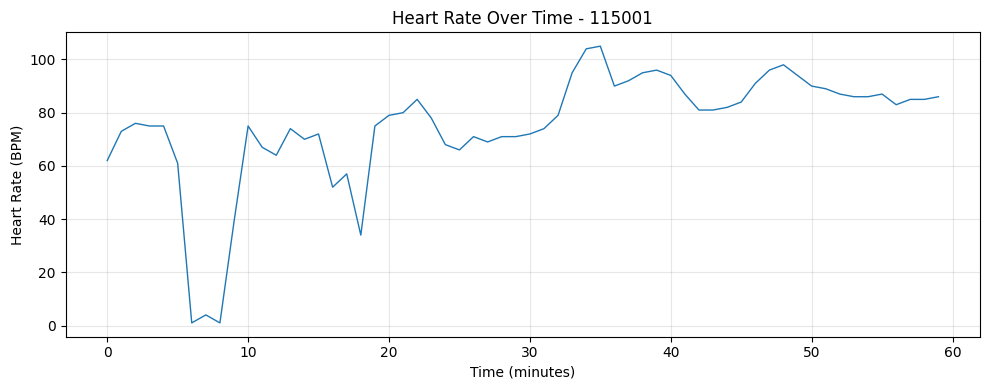

Processed 115001: 4499 R-peaks, 75.0 BPM avg

2. Batch Processing
------------------------------
Processing 18 ECG files from source1
File 1/18: 100001
Processed 100001: 4821 R-peaks, 80.3 BPM avg
File 2/18: 100002
Processed 100002: 3971 R-peaks, 66.2 BPM avg
File 3/18: 103001
Processed 103001: 3555 R-peaks, 59.2 BPM avg
File 4/18: 103002
Processed 103002: 4094 R-peaks, 68.2 BPM avg
File 5/18: 103003
Processed 103003: 4661 R-peaks, 77.7 BPM avg
File 6/18: 104001
Processed 104001: 4388 R-peaks, 73.1 BPM avg
File 7/18: 105001
Processed 105001: 4981 R-peaks, 83.0 BPM avg
File 8/18: 111001
Processed 111001: 4511 R-peaks, 75.2 BPM avg
File 9/18: 113001
Processed 113001: 5299 R-peaks, 88.3 BPM avg
File 10/18: 114001
Processed 114001: 5135 R-peaks, 85.6 BPM avg
File 11/18: 115001
Processed 115001: 4499 R-peaks, 75.0 BPM avg
File 12/18: 118001
Processed 118001: 4308 R-peaks, 71.8 BPM avg
File 13/18: 121001
Processed 121001: 4265 R-peaks, 71.1 BPM avg
File 14/18: 122001
Processed 122001: 3213 R

In [30]:
# =============================================================================
#  8. USAGE
# =============================================================================
# Run the complete pipeline
run_ecg_pipeline(max_files=None)

# Or run individual components:
# analyze_ecg_file("source1", "100001", plot=True)
# batch_results = analyze_ecg_batch("source1")
# eval_results = evaluate_batch("source2", max_duration_hours=1.0)
# anom_results = run_batch_analysis()

### Závěr

Na základě výše uvedených výstupů lze tvrdit, že systém je robustní a spolehlivý, ale stále není úplně přesný a ve výjimečných případech detekuje nedostatečně a je potřeba optimalizovat hodnoty.

Z grafu je patrné, že v určitých chvílích algoritmus nedetekuje žádné nebo velmi nízký počet R vrcholů a tím snižuje průměrnou hodnotu tepů za minutu. [Normální průměrná hodnota úderů za minutu](https://www.healthline.com/health/dangerous-heart-rate) se nachází v rozmezí 50-100 s převahou hodnot v rozmezí 60-100, což je ve všech 18 měřeních splněno.

Z výstupních statistik je vidět, že algoritmus dosahuje pozitivní prediktivní hodnoty měření téměř 100 %, což znamená, že prakticky nedetekuje šum v signálu, který není R vrcholem. O něco hůře už je na tom senzitivita. Zejména v měřeních 16773 a 19088 dosahuje hodnot pod 0.75 a zhoršuje tak celkové skóre, které je ale i tak ve všech případech nad 0,9. Výsledná senzitivita skýtá příležitost k další optimalizaci parametrů detekce, zejména prahu detekce.

Detekce anomálií trpí nedostatkem referenčních dat a výsledky to také potvrzují. Algoritmus detekuje vysoké množství anomálií v krátkých úsecích. Anotace jsou poskytnuty pouze pro delší úseky z celého měření a je hodnocena kvalita celého úseku. Z výsledků vyplývá pouze to, zda se systém shoduje s experty a v nekvalitních úsecích měření nalézá anomálie.

In [114]:
# =============================================================================
#  9. PARAMETER OPTIMIZATION
# =============================================================================

import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings("ignore")

def optimize_anomaly_parameters_optuna(data_dir: str,
                                     record_names: list = None,
                                     max_files: int = 5,
                                     max_duration_hours: float = 0.5,
                                     optimization_metric: str = "true_positives",
                                     n_trials: int = 100,
                                     timeout: int = 3600,  # 1 hour timeout
                                     verbose: bool = True):
    """
    Optimize ECG anomaly detection parameters using Optuna for efficient search.

    Args:
        data_dir: Directory containing ECG files
        record_names: Specific record names to use (if None, will auto-discover)
        max_files: Maximum number of files to use for optimization
        max_duration_hours: Maximum duration per file to process
        optimization_metric: Metric to optimize ("true_positives", "accuracy", "f1_score", "recall")
        n_trials: Maximum number of trials to run
        timeout: Maximum time in seconds for optimization
        verbose: Whether to print progress

    Returns:
        dict: Best parameters and performance metrics
    """

    # Get record names if not provided
    if record_names is None:
        import os
        if not os.path.exists(data_dir):
            print(f"Error: Directory {data_dir} not found!")
            return None

        ecg_files = [f for f in os.listdir(data_dir) if f.endswith("_ECG.hea")]
        record_names = sorted([f.replace("_ECG.hea", "") for f in ecg_files])

    # Limit number of files for optimization
    record_names = record_names[:max_files]

    if not record_names:
        print("No ECG files found!")
        return None

    print(f"Optimizing parameters using {len(record_names)} files:")
    print(f"Files: {record_names}")
    print(f"Using Optuna with {n_trials} trials and {timeout}s timeout")
    print(f"Optimizing for: {optimization_metric}")
    print("-" * 60)

    def objective(trial):
        """Optuna objective function to maximize."""

        # Sample parameters
        k_std = trial.suggest_float("k_std", 0.8, 3.0)
        flat_duration_sec = trial.suggest_float("flat_duration_sec", 0.5, 4.0)
        noise_duration_sec = trial.suggest_float("noise_duration_sec", 0.2, 1.5)
        noise_multiplier = trial.suggest_float("noise_multiplier", 0.5, 3.0)
        min_segment_length = trial.suggest_int("min_segment_length", 10, 150)
        merge_gap = trial.suggest_int("merge_gap", 10, 150)

        # Sample detection methods (categorical with multiple selection)
        use_amplitude = trial.suggest_categorical("use_amplitude", [True, False])
        use_flatline = trial.suggest_categorical("use_flatline", [True, False])
        use_noise = trial.suggest_categorical("use_noise", [True, False])

        # Ensure at least one method is selected
        methods = []
        if use_amplitude:
            methods.append("amplitude")
        if use_flatline:
            methods.append("flatline")
        if use_noise:
            methods.append("noise")

        if not methods:
            methods = ["amplitude"]  # Default fallback

        # Create parameter dict
        params = {
            "k_std": k_std,
            "flat_duration_sec": flat_duration_sec,
            "noise_duration_sec": noise_duration_sec,
            "noise_multiplier": noise_multiplier,
            "min_segment_length": min_segment_length,
            "merge_gap": merge_gap
        }

        # Test this parameter combination across all files
        total_true_positives = 0
        total_gt_intervals = 0
        total_detected = 0
        total_accuracy = 0
        successful_files = 0

        for record_name in record_names:
            try:
                # Run anomaly detection with current parameters
                result = analyze_ecg_anomalies(
                    data_dir=data_dir,
                    record_name=record_name,
                    detection_methods=methods,
                    plot=False,
                    max_duration_hours=max_duration_hours,
                    **params
                )

                total_true_positives += result.true_positives
                total_gt_intervals += result.total_gt
                total_detected += result.total_detected
                total_accuracy += result.accuracy
                successful_files += 1

            except Exception as e:
                # Penalize failed trials
                continue

        if successful_files == 0:
            return 0  # Return 0 for failed trials

        # Calculate aggregate metrics
        overall_accuracy = total_true_positives / total_gt_intervals if total_gt_intervals > 0 else 0
        precision = total_true_positives / total_detected if total_detected > 0 else 0
        recall = total_true_positives / total_gt_intervals if total_gt_intervals > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        # Store intermediate values for analysis
        trial.set_user_attr("total_true_positives", total_true_positives)
        trial.set_user_attr("total_gt_intervals", total_gt_intervals)
        trial.set_user_attr("total_detected", total_detected)
        trial.set_user_attr("overall_accuracy", overall_accuracy)
        trial.set_user_attr("precision", precision)
        trial.set_user_attr("recall", recall)
        trial.set_user_attr("f1_score", f1_score)
        trial.set_user_attr("successful_files", successful_files)
        trial.set_user_attr("methods", methods)

        # Return optimization metric
        if optimization_metric == "true_positives":
            return total_true_positives
        elif optimization_metric == "accuracy":
            return overall_accuracy
        elif optimization_metric == "f1_score":
            return f1_score
        elif optimization_metric == "recall":
            return recall
        elif optimization_metric == "precision":
            return precision
        else:
            return total_true_positives  # Default

    # Create and run study
    sampler = TPESampler(seed=42)  # Reproducible results
    study = optuna.create_study(
        direction="maximize",
        sampler=sampler,
        study_name="ecg_anomaly_optimization"
    )

    # Run optimization
    study.optimize(
        objective,
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=verbose
    )

    # Get best results
    best_trial = study.best_trial
    best_params = {k: v for k, v in best_trial.params.items()
                  if not k.startswith("use_")}

    # Reconstruct best methods
    best_methods = []
    if best_trial.params.get("use_amplitude", False):
        best_methods.append("amplitude")
    if best_trial.params.get("use_flatline", False):
        best_methods.append("flatline")
    if best_trial.params.get("use_noise", False):
        best_methods.append("noise")

    if not best_methods:
        best_methods = ["amplitude"]

    # Create results dataframe
    trials_df = study.trials_dataframe()

    print("\n" + "="*60)
    print("OPTUNA OPTIMIZATION RESULTS")
    print("="*60)
    print(f"Best {optimization_metric}: {study.best_value:.3f}")
    print(f"Best trial number: {best_trial.number}")
    print(f"Total trials completed: {len(study.trials)}")
    print(f"Best methods: {best_methods}")
    print(f"Best parameters:")
    for param, value in best_params.items():
        print(f"  {param}: {value:.3f}" if isinstance(value, float) else f"  {param}: {value}")

    # Show performance metrics for best trial
    best_attrs = best_trial.user_attrs
    print(f"\nBest trial performance:")
    print(f"  True Positives: {best_attrs.get("total_true_positives", "N/A")}")
    print(f"  Accuracy: {best_attrs.get("overall_accuracy", 0):.3f}")
    print(f"  Precision: {best_attrs.get("precision", 0):.3f}")
    print(f"  Recall: {best_attrs.get("recall", 0):.3f}")
    print(f"  F1 Score: {best_attrs.get("f1_score", 0):.3f}")

    # Show top 5 trials
    top_trials = sorted(study.trials, key=lambda t: t.value or 0, reverse=True)[:5]
    print(f"\nTop 5 trials:")
    print("-" * 40)
    for i, trial in enumerate(top_trials):
        if trial.value is not None:
            methods_str = trial.user_attrs.get("methods", [])
            print(f"{i+1}. Score: {trial.value:.3f} | Trial: {trial.number} | "
                  f"Methods: {methods_str} | TP: {trial.user_attrs.get("total_true_positives", 0)}")

    return {
        "best_params": best_params,
        "best_methods": best_methods,
        "best_score": study.best_value,
        "best_trial": best_trial,
        "optimization_metric": optimization_metric,
        "study": study,
        "trials_df": trials_df,
        "summary": {
            "total_trials": len(study.trials),
            "files_used": record_names,
            "best_true_positives": best_attrs.get("total_true_positives", 0),
            "best_accuracy": best_attrs.get("overall_accuracy", 0),
            "best_precision": best_attrs.get("precision", 0),
            "best_recall": best_attrs.get("recall", 0),
            "best_f1_score": best_attrs.get("f1_score", 0)
        }
    }

def quick_optuna_optimization(data_dir: str,
                            max_files: int = 3,
                            max_duration_hours: float = 0.25,
                            n_trials: int = 50):
    """Quick Optuna optimization with fewer trials."""
    print("Running QUICK Optuna optimization...")
    print(f"Using {n_trials} trials for faster results")

    return optimize_anomaly_parameters_optuna(
        data_dir=data_dir,
        max_files=max_files,
        max_duration_hours=max_duration_hours,
        optimization_metric="true_positives",
        n_trials=n_trials,
        timeout=1800,  # 30 minutes
        verbose=True
    )

def comprehensive_optuna_optimization(data_dir: str,
                                    max_files: int = 5,
                                    max_duration_hours: float = 0.5,
                                    n_trials: int = 200):
    """Comprehensive Optuna optimization with more trials."""
    print("Running COMPREHENSIVE Optuna optimization...")
    print(f"Using {n_trials} trials for thorough search")

    return optimize_anomaly_parameters_optuna(
        data_dir=data_dir,
        max_files=max_files,
        max_duration_hours=max_duration_hours,
        optimization_metric="true_positives",
        n_trials=n_trials,
        timeout=36000,  # 2 hours
        verbose=False
    )

def multi_objective_optimization(data_dir: str,
                               max_files: int = 5,
                               max_duration_hours: float = 0.5,
                               n_trials: int = 150):
    """
    Run optimization for multiple objectives and compare results.
    """
    print("Running MULTI-OBJECTIVE optimization...")

    objectives = ["true_positives", "accuracy", "f1_score", "recall"]
    results = {}

    for objective in objectives:
        print(f"\nOptimizing for: {objective}")
        print("-" * 30)

        result = optimize_anomaly_parameters_optuna(
            data_dir=data_dir,
            max_files=max_files,
            max_duration_hours=max_duration_hours,
            optimization_metric=objective,
            n_trials=n_trials,
            timeout=1800,  # 30 minutes per objective
            verbose=False
        )

        results[objective] = result

    # Compare results
    print("\n" + "="*80)
    print("MULTI-OBJECTIVE COMPARISON")
    print("="*80)

    comparison_data = []
    for obj, result in results.items():
        if result:
            comparison_data.append({
                "Objective": obj,
                "Best_Score": result["best_score"],
                "True_Positives": result["summary"]["best_true_positives"],
                "Accuracy": result["summary"]["best_accuracy"],
                "Precision": result["summary"]["best_precision"],
                "Recall": result["summary"]["best_recall"],
                "F1_Score": result["summary"]["best_f1_score"],
                "Methods": result["best_methods"]
            })

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False, float_format="%.3f"))

    return results

# Usage examples:

def run_quick_optuna():
    """Run quick Optuna optimization"""
    return quick_optuna_optimization(
        data_dir="source1",  # Update with your data directory
        max_files=3,
        max_duration_hours=0.25,
        n_trials=50
    )

def run_comprehensive_optuna():
    """Run comprehensive Optuna optimization"""
    return comprehensive_optuna_optimization(
        data_dir="source1",  # Update with your data directory
        max_files=14,
        max_duration_hours=0.5,
        n_trials=200
    )

def run_multi_objective():
    """Run multi-objective optimization"""
    return multi_objective_optimization(
        data_dir="source1",  # Update with your data directory
        max_files=4,
        max_duration_hours=0.4,
        n_trials=100
    )

# Run quick optimization by default
print("Running comprehensive optimization...")
optimal_results = run_comprehensive_optuna()


[I 2025-06-21 23:48:11,530] A new study created in memory with name: ecg_anomaly_optimization


Running comprehensive optimization...
Running COMPREHENSIVE Optuna optimization...
Using 200 trials for thorough search
Optimizing parameters using 14 files:
Files: ['100001', '100002', '103001', '103002', '103003', '104001', '105001', '111001', '113001', '114001', '115001', '118001', '121001', '122001']
Using Optuna with 200 trials and 36000s timeout
Optimizing for: true_positives
------------------------------------------------------------


[I 2025-06-21 23:48:12,661] Trial 0 finished with value: 1.0 and parameters: {'k_std': 1.6239882614641976, 'flat_duration_sec': 3.827500072434707, 'noise_duration_sec': 1.1515921243548266, 'noise_multiplier': 1.9966462104925915, 'min_segment_length': 31, 'merge_gap': 31, 'use_amplitude': False, 'use_flatline': False, 'use_noise': False}. Best is trial 0 with value: 1.0.
[I 2025-06-21 23:48:13,985] Trial 1 finished with value: 1.0 and parameters: {'k_std': 2.631373809760928, 'flat_duration_sec': 1.2431868873739664, 'noise_duration_sec': 0.4363724573692308, 'noise_multiplier': 0.9585112746335845, 'min_segment_length': 52, 'merge_gap': 83, 'use_amplitude': True, 'use_flatline': True, 'use_noise': False}. Best is trial 0 with value: 1.0.
[I 2025-06-21 23:48:16,221] Trial 2 finished with value: 2.0 and parameters: {'k_std': 1.8033539652774793, 'flat_duration_sec': 3.2481158648755475, 'noise_duration_sec': 0.4595759168058677, 'noise_multiplier': 1.785586096034029, 'min_segment_length': 93, '


OPTUNA OPTIMIZATION RESULTS
Best true_positives: 26.000
Best trial number: 64
Total trials completed: 200
Best methods: ['noise']
Best parameters:
  k_std: 0.802
  flat_duration_sec: 2.179
  noise_duration_sec: 0.573
  noise_multiplier: 0.516
  min_segment_length: 78
  merge_gap: 98

Best trial performance:
  True Positives: 26
  Accuracy: 0.007
  Precision: 0.001
  Recall: 0.007
  F1 Score: 0.002

Top 5 trials:
----------------------------------------
1. Score: 26.000 | Trial: 64 | Methods: ['noise'] | TP: 26
2. Score: 25.000 | Trial: 53 | Methods: ['noise'] | TP: 25
3. Score: 25.000 | Trial: 119 | Methods: ['noise'] | TP: 25
4. Score: 25.000 | Trial: 121 | Methods: ['noise'] | TP: 25
5. Score: 25.000 | Trial: 122 | Methods: ['noise'] | TP: 25
